In [13]:
import os
import jsonlines
import json
import pickle

path = "/mnt/disks/storage/data/finetune_data/9784kL.jsonl"
pickle_path = os.path.expanduser("~/image_paths.pkl")


image_paths = set()
if os.path.exists(pickle_path):
    with open(pickle_path, "rb") as f:
        image_paths = pickle.load(f)
        print(f"Loaded {len(image_paths)} image paths")

else:
    with jsonlines.open(path) as reader:
        for line in reader:
            obj = json.loads(line)
            if "image" in obj:
                image_paths.add(obj["image"])

# save as a pickle 
with open(pickle_path, "wb") as f:
    pickle.dump(image_paths, f)
    print(f"Saved {len(image_paths)} image paths")

print(f"Total number of image paths: {len(image_paths)}")


Loaded 3898574 image paths
Saved 3898574 image paths
Total number of image paths: 3898574


In [5]:
obj = json.loads(line)
obj

{'id': '000000033471',
 'image': 'coco/train2017/000000033471.jpg',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat are the colors of the bus in the image?'},
  {'from': 'gpt', 'value': 'The bus in the image is white and red.'},
  {'from': 'human',
   'value': 'What feature can be seen on the back of the bus?'},
  {'from': 'gpt', 'value': 'The back of the bus features an advertisement.'},
  {'from': 'human',
   'value': 'Is the bus driving down the street or pulled off to the side?'},
  {'from': 'gpt',
   'value': 'The bus is driving down the street, which is crowded with people and other vehicles.'}],
 'source': 'sharegpt4v_mix665k_cap23k_coco-ap9k_lcs3k_sam9k_div2k.json'}

In [26]:
# display the image
from PIL import Image

base_path = "/mnt/disks/storage/data/finetune_data/"
image_path = os.path.join(base_path, obj["image"])
image = Image.open(image_path)
image

NameError: name 'obj' is not defined

In [18]:
list(image_paths)[0]

'websight/images/train_238836.png'

In [1]:
import os
import pickle
import json
from PIL import Image

# Parameters
HASH_SIZE = 8  # Should match the hash size used previously
THRESHOLD = 1  # Hamming distance threshold for matching
INDEX_FILENAME = "faiss_index_train_phash.index"  # Path to the FAISS index file
IMAGE_PATHS_PICKLE = os.path.expanduser("~/image_paths.pkl")  # Path to the training image paths
TEST_HASH_FILES_DIR = os.path.expanduser("~/test_hash_files")  # Directory where test hashes are saved
RESULTS_DIR = os.path.expanduser("~/match_results_exact")  # Directory to save the results

base_path = "/mnt/disks/storage/data/finetune_data/"


In [7]:
from datasets import load_dataset, concatenate_datasets
from huggingface_hub import hf_hub_download

test_dataset_map = dict(
    # name=("dataset_name", "version", "split", "image_key"
    ade=("SaiCharithaAkula21/benchmark_ade_manual", None, "train", "image"),
    ai2d=("lmms-lab/ai2d", None, "test", "image"),
    blink=("BLINK-Benchmark/BLINK", ["Counting", "IQ_Test", "Object_Localization", "Relative_Depth", "Relative_Reflectance", "Spatial_Relation"], "val", "image_1"),
    chartqa=("lmms-lab/ChartQA", None, "test", "image"),
    coco=("SaiCharithaAkula21/benchmark_coco_filtered", None, "train", "image"),
    docvqa=("lmms-lab/DocVQA", "DocVQA", "test", "image"),
    gqa=("lmms-lab/GQA", "testdev_balanced_images", "testdev", "image"),
    infovqa=("lmms-lab/DocVQA", "InfographicVQA", "test", "image"),
    mathvista=("AI4Math/MathVista", None, "testmini", "decoded_image"),
    mmbench_cn=("lmms-lab/MMBench_CN", "default", "dev", "image"),
    mmbench_en=("lmms-lab/MMBench_EN", None, "dev", "image"),
    mme=("lmms-lab/MME", None, "test", "image"),
    mmmu=("lmms-lab/MMMU", None, "validation", "image_1"),
    mmstar=("Lin-Chen/MMStar", None, "val", "image"),
    mmvet=("lmms-lab/MMVet", None, "test", "image"),
    mmvp=("MMVP/MMVP", None, "train", "image"),
    ocrbench=("echo840/OCRBench", None, "test", "image"),
    cvbench=("nyu-visionx/CV-Bench", None, "test", "image"),
    pope=("lmms-lab/POPE", None, "test", "image"),
    realworldqa=("lmms-lab/RealWorldQA", None, "test", "image"),
    sqa=("derek-thomas/ScienceQA", None, "test", "image"),
    seed=("lmms-lab/SEED-Bench", None, "test", "image"),
    stvqa=("lmms-lab/ST-VQA", None, "test", "image"),
    synthdog=("naver-clova-ix/synthdog-en", None, "validation", "image"),
    textvqa=("lmms-lab/textvqa", None, "validation", "image"),
    vizwiz=("lmms-lab/VizWiz-VQA", None, ("val", "test"), "image"),
    vstar=("craigwu/vstar_bench", None, "test", "image"),
)

def get_dataset(name):
    dataset_name, version, split = test_dataset_map[name][:3]

    if isinstance(version, list):
        datasets = []
        for v in version:
            datasets.append(load_dataset(dataset_name, v, split=split))
        return concatenate_datasets(datasets)

    if isinstance(split, tuple):
        datasets = []
        for s in split:
            datasets.append(load_dataset(dataset_name, version, split=s))
        return concatenate_datasets(datasets)

    return load_dataset(dataset_name, version, split=split)


def load_image(data, key):
    """Process a single image and compute its hash."""
    try:
        img = data[key]
        if img is None:
            # if name != "sqa":
            #     raise ValueError("Image is None")
            img = data[1][key]
        if isinstance(img, list):
            # if name != "seed":
            #     raise ValueError("Image is a list")
            img = img[0]
        if isinstance(img, str):
            # if name != "vstar":
            #     # print("Image is a string")
            #     raise ValueError("Image is a string")
            sub_folder, image_id = img.split('/')
            path = hf_hub_download(repo_id="craigwu/vstar_bench", filename=image_id, subfolder=sub_folder, repo_type="dataset")
            img = Image.open(path)

        image = img.convert('RGB')

        return image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

In [8]:


# Load match results for a specific dataset
dataset_name = 'gqa'
results_file = os.path.join(RESULTS_DIR, f"{dataset_name}_matches.json")
with open(results_file, 'r') as f:
    data = json.load(f)

# Access match information
total_test_images = data['total_test_images']
n_test_images_with_match = data['n_test_images_with_match']
test_matches = data['test_matches']

print(f"{dataset_name}: {n_test_images_with_match}/{total_test_images} test images have matches in the training set.")

# For example, print matches for the first test image with matches
for test_idx, match_info in test_matches.items():
    print(f"Test image index: {test_idx}")
    print("Matched training indices:", match_info['matched_training_indices'])
    print("Matched training filenames:", match_info['matched_training_filenames'])
    break  # Remove this line to iterate over all matches


gqa: 1/398 test images have matches in the training set.
Test image index: 332
Matched training indices: [325980]
Matched training filenames: ['hfdata/robut_wikisql/71653.jpg']


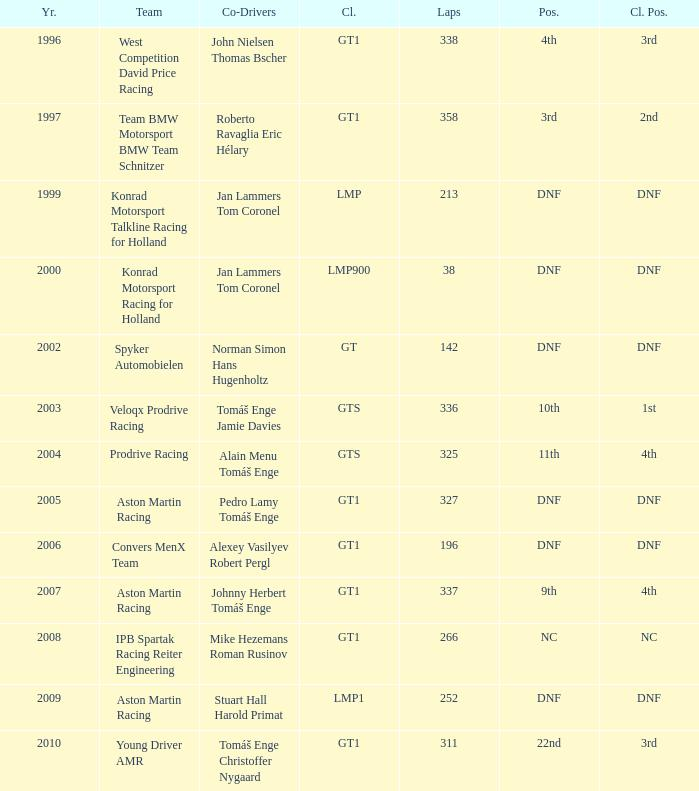

In [9]:
Image.open(base_path + match_info['matched_training_filenames'][0])

Path: /mnt/disks/storage/data/finetune_data/hfdata/robut_wikisql/71653.jpg, type: <class 'PIL.Image.Image'>


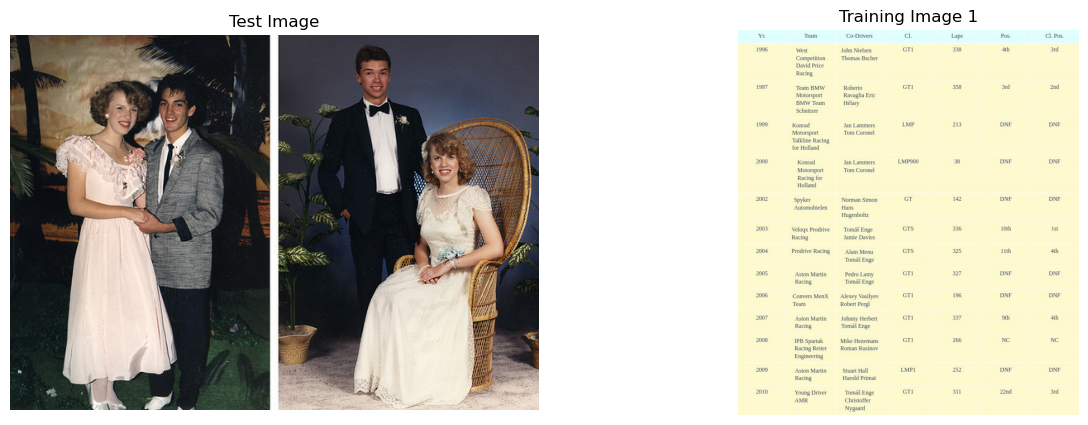

In [10]:
from PIL import Image
import matplotlib.pyplot as plt


def visualize_match(test_image, training_image_paths):
    fig, axes = plt.subplots(1, len(training_image_paths) + 1, figsize=(15, 5))
    axes[0].imshow(test_image)
    axes[0].set_title('Test Image')
    axes[0].axis('off')
    
    for idx, train_image_path in enumerate(training_image_paths):
        train_image_full_path = os.path.join(base_path, train_image_path)  # Adjust base_path as needed
        train_image = Image.open(train_image_full_path).convert('RGB')
        print(f"Path: {train_image_full_path}, type: {type(train_image)}")
        axes[idx + 1].imshow(train_image)
        axes[idx + 1].set_title(f'Training Image {idx+1}')
        axes[idx + 1].axis('off')
    
    plt.show()

# Example usage

dataset = get_dataset(dataset_name)
for test_idx, match_info in test_matches.items():
    test_row = dataset.select([int(test_idx)])
    test_key = test_dataset_map[dataset_name][3]
    test_image = load_image(test_row, test_key)
    training_image_paths = match_info['matched_training_filenames']
    visualize_match(test_image, training_image_paths)


In [6]:
import imagehash
from PIL import Image

import matplotlib.pyplot as plt
from tqdm import tqdm

def visualize_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Loop through all images in the dataset
for idx, row in tqdm(enumerate(dataset), total=len(dataset)):
    try:
        # Load the image
        image = row[test_key]
        if isinstance(image, str):
            image_path = os.path.join(base_path, image)
            image = Image.open(image_path).convert('RGB')
        elif isinstance(image, Image.Image):
            image = image.convert('RGB')
        else:
            continue

        # Compute the hash
        procesed_image = image.convert('L').resize((256, 256))
        image_hash = imagehash.phash(image, hash_size=HASH_SIZE)
        image_hash_int = int(str(image_hash), 16)

        # Check if the hash matches any train or test hash
        if image_hash_int in train_hashes or image_hash_int in test_matches:
            visualize_image(image, f"Image {idx} with hash {image_hash_int}")

    except Exception as e:
        print(f"Error processing image {idx}: {e}")

  3%|▎         | 11/398 [00:00<00:04, 95.94it/s]

Error processing image 0: name 'train_hashes' is not defined
Error processing image 1: name 'train_hashes' is not defined
Error processing image 2: name 'train_hashes' is not defined
Error processing image 3: name 'train_hashes' is not defined
Error processing image 4: name 'train_hashes' is not defined
Error processing image 5: name 'train_hashes' is not defined
Error processing image 6: name 'train_hashes' is not defined
Error processing image 7: name 'train_hashes' is not defined
Error processing image 8: name 'train_hashes' is not defined
Error processing image 9: name 'train_hashes' is not defined
Error processing image 10: name 'train_hashes' is not defined
Error processing image 11: name 'train_hashes' is not defined
Error processing image 12: name 'train_hashes' is not defined
Error processing image 13: name 'train_hashes' is not defined
Error processing image 14: name 'train_hashes' is not defined


  8%|▊         | 30/398 [00:00<00:05, 72.33it/s]

Error processing image 15: name 'train_hashes' is not defined
Error processing image 16: name 'train_hashes' is not defined
Error processing image 17: name 'train_hashes' is not defined
Error processing image 18: name 'train_hashes' is not defined
Error processing image 19: name 'train_hashes' is not defined
Error processing image 20: name 'train_hashes' is not defined
Error processing image 21: name 'train_hashes' is not defined
Error processing image 22: name 'train_hashes' is not defined
Error processing image 23: name 'train_hashes' is not defined
Error processing image 24: name 'train_hashes' is not defined
Error processing image 25: name 'train_hashes' is not defined
Error processing image 26: name 'train_hashes' is not defined
Error processing image 27: name 'train_hashes' is not defined
Error processing image 28: name 'train_hashes' is not defined
Error processing image 29: name 'train_hashes' is not defined
Error processing image 30: name 'train_hashes' is not defined
Error pr

 10%|█         | 41/398 [00:00<00:04, 84.53it/s]

Error processing image 35: name 'train_hashes' is not defined
Error processing image 36: name 'train_hashes' is not defined
Error processing image 37: name 'train_hashes' is not defined
Error processing image 38: name 'train_hashes' is not defined
Error processing image 39: name 'train_hashes' is not defined
Error processing image 40: name 'train_hashes' is not defined
Error processing image 41: name 'train_hashes' is not defined
Error processing image 42: name 'train_hashes' is not defined
Error processing image 43: name 'train_hashes' is not defined
Error processing image 44: name 'train_hashes' is not defined
Error processing image 45: name 'train_hashes' is not defined
Error processing image 46: name 'train_hashes' is not defined
Error processing image 47: name 'train_hashes' is not defined
Error processing image 48: name 'train_hashes' is not defined
Error processing image 49: name 'train_hashes' is not defined


 16%|█▋        | 65/398 [00:00<00:03, 87.27it/s]

Error processing image 50: name 'train_hashes' is not defined
Error processing image 51: name 'train_hashes' is not defined
Error processing image 52: name 'train_hashes' is not defined
Error processing image 53: name 'train_hashes' is not defined
Error processing image 54: name 'train_hashes' is not defined
Error processing image 55: name 'train_hashes' is not defined
Error processing image 56: name 'train_hashes' is not defined
Error processing image 57: name 'train_hashes' is not defined
Error processing image 58: name 'train_hashes' is not defined
Error processing image 59: name 'train_hashes' is not defined
Error processing image 60: name 'train_hashes' is not defined
Error processing image 61: name 'train_hashes' is not defined
Error processing image 62: name 'train_hashes' is not defined
Error processing image 63: name 'train_hashes' is not defined
Error processing image 64: name 'train_hashes' is not defined
Error processing image 65: name 'train_hashes' is not defined
Error pr

 22%|██▏       | 88/398 [00:01<00:03, 90.18it/s]

Error processing image 67: name 'train_hashes' is not defined
Error processing image 68: name 'train_hashes' is not defined
Error processing image 69: name 'train_hashes' is not defined
Error processing image 70: name 'train_hashes' is not defined
Error processing image 71: name 'train_hashes' is not defined
Error processing image 72: name 'train_hashes' is not defined
Error processing image 73: name 'train_hashes' is not defined
Error processing image 74: name 'train_hashes' is not defined
Error processing image 75: name 'train_hashes' is not defined
Error processing image 76: name 'train_hashes' is not defined
Error processing image 77: name 'train_hashes' is not defined
Error processing image 78: name 'train_hashes' is not defined
Error processing image 79: name 'train_hashes' is not defined
Error processing image 80: name 'train_hashes' is not defined
Error processing image 81: name 'train_hashes' is not defined
Error processing image 82: name 'train_hashes' is not defined
Error pr

 28%|██▊       | 111/398 [00:01<00:03, 92.79it/s]

Error processing image 92: name 'train_hashes' is not defined
Error processing image 93: name 'train_hashes' is not defined
Error processing image 94: name 'train_hashes' is not defined
Error processing image 95: name 'train_hashes' is not defined
Error processing image 96: name 'train_hashes' is not defined
Error processing image 97: name 'train_hashes' is not defined
Error processing image 98: name 'train_hashes' is not defined
Error processing image 99: name 'train_hashes' is not defined
Error processing image 100: name 'train_hashes' is not defined
Error processing image 101: name 'train_hashes' is not defined
Error processing image 102: name 'train_hashes' is not defined
Error processing image 103: name 'train_hashes' is not defined
Error processing image 104: name 'train_hashes' is not defined
Error processing image 105: name 'train_hashes' is not defined
Error processing image 106: name 'train_hashes' is not defined
Error processing image 107: name 'train_hashes' is not defined


 34%|███▍      | 137/398 [00:01<00:02, 106.32it/s]

Error processing image 113: name 'train_hashes' is not defined
Error processing image 114: name 'train_hashes' is not defined
Error processing image 115: name 'train_hashes' is not defined
Error processing image 116: name 'train_hashes' is not defined
Error processing image 117: name 'train_hashes' is not defined
Error processing image 118: name 'train_hashes' is not defined
Error processing image 119: name 'train_hashes' is not defined
Error processing image 120: name 'train_hashes' is not defined
Error processing image 121: name 'train_hashes' is not defined
Error processing image 122: name 'train_hashes' is not defined
Error processing image 123: name 'train_hashes' is not defined
Error processing image 124: name 'train_hashes' is not defined
Error processing image 125: name 'train_hashes' is not defined
Error processing image 126: name 'train_hashes' is not defined
Error processing image 127: name 'train_hashes' is not defined
Error processing image 128: name 'train_hashes' is not 

 37%|███▋      | 148/398 [00:01<00:02, 106.97it/s]

Error processing image 137: name 'train_hashes' is not defined
Error processing image 138: name 'train_hashes' is not defined
Error processing image 139: name 'train_hashes' is not defined
Error processing image 140: name 'train_hashes' is not defined
Error processing image 141: name 'train_hashes' is not defined
Error processing image 142: name 'train_hashes' is not defined
Error processing image 143: name 'train_hashes' is not defined
Error processing image 144: name 'train_hashes' is not defined
Error processing image 145: name 'train_hashes' is not defined
Error processing image 146: name 'train_hashes' is not defined
Error processing image 147: name 'train_hashes' is not defined
Error processing image 148: name 'train_hashes' is not defined
Error processing image 149: name 'train_hashes' is not defined
Error processing image 150: name 'train_hashes' is not defined
Error processing image 151: name 'train_hashes' is not defined
Error processing image 152: name 'train_hashes' is not 

 42%|████▏     | 169/398 [00:01<00:02, 84.96it/s] 

Error processing image 156: name 'train_hashes' is not defined
Error processing image 157: name 'train_hashes' is not defined
Error processing image 158: name 'train_hashes' is not defined
Error processing image 159: name 'train_hashes' is not defined
Error processing image 160: name 'train_hashes' is not defined
Error processing image 161: name 'train_hashes' is not defined
Error processing image 162: name 'train_hashes' is not defined
Error processing image 163: name 'train_hashes' is not defined
Error processing image 164: name 'train_hashes' is not defined
Error processing image 165: name 'train_hashes' is not defined
Error processing image 166: name 'train_hashes' is not defined
Error processing image 167: name 'train_hashes' is not defined
Error processing image 168: name 'train_hashes' is not defined
Error processing image 169: name 'train_hashes' is not defined
Error processing image 170: name 'train_hashes' is not defined
Error processing image 171: name 'train_hashes' is not 

 45%|████▌     | 180/398 [00:02<00:02, 91.08it/s]

Error processing image 176: name 'train_hashes' is not defined
Error processing image 177: name 'train_hashes' is not defined
Error processing image 178: name 'train_hashes' is not defined
Error processing image 179: name 'train_hashes' is not defined
Error processing image 180: name 'train_hashes' is not defined
Error processing image 181: name 'train_hashes' is not defined
Error processing image 182: name 'train_hashes' is not defined
Error processing image 183: name 'train_hashes' is not defined
Error processing image 184: name 'train_hashes' is not defined
Error processing image 185: name 'train_hashes' is not defined
Error processing image 186: name 'train_hashes' is not defined
Error processing image 187: name 'train_hashes' is not defined


 51%|█████     | 202/398 [00:02<00:02, 87.90it/s]

Error processing image 188: name 'train_hashes' is not defined
Error processing image 189: name 'train_hashes' is not defined
Error processing image 190: name 'train_hashes' is not defined
Error processing image 191: name 'train_hashes' is not defined
Error processing image 192: name 'train_hashes' is not defined
Error processing image 193: name 'train_hashes' is not defined
Error processing image 194: name 'train_hashes' is not defined
Error processing image 195: name 'train_hashes' is not defined
Error processing image 196: name 'train_hashes' is not defined
Error processing image 197: name 'train_hashes' is not defined
Error processing image 198: name 'train_hashes' is not defined
Error processing image 199: name 'train_hashes' is not defined
Error processing image 200: name 'train_hashes' is not defined
Error processing image 201: name 'train_hashes' is not defined
Error processing image 202: name 'train_hashes' is not defined
Error processing image 203: name 'train_hashes' is not 

 56%|█████▌    | 222/398 [00:02<00:02, 82.80it/s]

Error processing image 207: name 'train_hashes' is not defined
Error processing image 208: name 'train_hashes' is not defined
Error processing image 209: name 'train_hashes' is not defined
Error processing image 210: name 'train_hashes' is not defined
Error processing image 211: name 'train_hashes' is not defined
Error processing image 212: name 'train_hashes' is not defined
Error processing image 213: name 'train_hashes' is not defined
Error processing image 214: name 'train_hashes' is not defined
Error processing image 215: name 'train_hashes' is not defined
Error processing image 216: name 'train_hashes' is not defined
Error processing image 217: name 'train_hashes' is not defined
Error processing image 218: name 'train_hashes' is not defined
Error processing image 219: name 'train_hashes' is not defined
Error processing image 220: name 'train_hashes' is not defined
Error processing image 221: name 'train_hashes' is not defined
Error processing image 222: name 'train_hashes' is not 

 62%|██████▏   | 245/398 [00:02<00:01, 97.06it/s]

Error processing image 226: name 'train_hashes' is not defined
Error processing image 227: name 'train_hashes' is not defined
Error processing image 228: name 'train_hashes' is not defined
Error processing image 229: name 'train_hashes' is not defined
Error processing image 230: name 'train_hashes' is not defined
Error processing image 231: name 'train_hashes' is not defined
Error processing image 232: name 'train_hashes' is not defined
Error processing image 233: name 'train_hashes' is not defined
Error processing image 234: name 'train_hashes' is not defined
Error processing image 235: name 'train_hashes' is not defined
Error processing image 236: name 'train_hashes' is not defined
Error processing image 237: name 'train_hashes' is not defined
Error processing image 238: name 'train_hashes' is not defined
Error processing image 239: name 'train_hashes' is not defined
Error processing image 240: name 'train_hashes' is not defined
Error processing image 241: name 'train_hashes' is not 

 65%|██████▍   | 257/398 [00:02<00:01, 101.26it/s]

Error processing image 253: name 'train_hashes' is not defined
Error processing image 254: name 'train_hashes' is not defined
Error processing image 255: name 'train_hashes' is not defined
Error processing image 256: name 'train_hashes' is not defined
Error processing image 257: name 'train_hashes' is not defined
Error processing image 258: name 'train_hashes' is not defined
Error processing image 259: name 'train_hashes' is not defined
Error processing image 260: name 'train_hashes' is not defined
Error processing image 261: name 'train_hashes' is not defined
Error processing image 262: name 'train_hashes' is not defined


 71%|███████   | 281/398 [00:03<00:01, 85.20it/s] 

Error processing image 263: name 'train_hashes' is not defined
Error processing image 264: name 'train_hashes' is not defined
Error processing image 265: name 'train_hashes' is not defined
Error processing image 266: name 'train_hashes' is not defined
Error processing image 267: name 'train_hashes' is not defined
Error processing image 268: name 'train_hashes' is not defined
Error processing image 269: name 'train_hashes' is not defined
Error processing image 270: name 'train_hashes' is not defined
Error processing image 271: name 'train_hashes' is not defined
Error processing image 272: name 'train_hashes' is not defined
Error processing image 273: name 'train_hashes' is not defined
Error processing image 274: name 'train_hashes' is not defined
Error processing image 275: name 'train_hashes' is not defined
Error processing image 276: name 'train_hashes' is not defined
Error processing image 277: name 'train_hashes' is not defined
Error processing image 278: name 'train_hashes' is not 

 77%|███████▋  | 305/398 [00:03<00:00, 95.04it/s]

Error processing image 287: name 'train_hashes' is not defined
Error processing image 288: name 'train_hashes' is not defined
Error processing image 289: name 'train_hashes' is not defined
Error processing image 290: name 'train_hashes' is not defined
Error processing image 291: name 'train_hashes' is not defined
Error processing image 292: name 'train_hashes' is not defined
Error processing image 293: name 'train_hashes' is not defined
Error processing image 294: name 'train_hashes' is not defined
Error processing image 295: name 'train_hashes' is not defined
Error processing image 296: name 'train_hashes' is not defined
Error processing image 297: name 'train_hashes' is not defined
Error processing image 298: name 'train_hashes' is not defined
Error processing image 299: name 'train_hashes' is not defined
Error processing image 300: name 'train_hashes' is not defined
Error processing image 301: name 'train_hashes' is not defined
Error processing image 302: name 'train_hashes' is not 

 83%|████████▎ | 329/398 [00:03<00:00, 98.50it/s]

Error processing image 307: name 'train_hashes' is not defined
Error processing image 308: name 'train_hashes' is not defined
Error processing image 309: name 'train_hashes' is not defined
Error processing image 310: name 'train_hashes' is not defined
Error processing image 311: name 'train_hashes' is not defined
Error processing image 312: name 'train_hashes' is not defined
Error processing image 313: name 'train_hashes' is not defined
Error processing image 314: name 'train_hashes' is not defined
Error processing image 315: name 'train_hashes' is not defined
Error processing image 316: name 'train_hashes' is not defined
Error processing image 317: name 'train_hashes' is not defined
Error processing image 318: name 'train_hashes' is not defined
Error processing image 319: name 'train_hashes' is not defined
Error processing image 320: name 'train_hashes' is not defined
Error processing image 321: name 'train_hashes' is not defined
Error processing image 322: name 'train_hashes' is not 

 89%|████████▉ | 354/398 [00:03<00:00, 103.98it/s]

Error processing image 333: name 'train_hashes' is not defined
Error processing image 334: name 'train_hashes' is not defined
Error processing image 335: name 'train_hashes' is not defined
Error processing image 336: name 'train_hashes' is not defined
Error processing image 337: name 'train_hashes' is not defined
Error processing image 338: name 'train_hashes' is not defined
Error processing image 339: name 'train_hashes' is not defined
Error processing image 340: name 'train_hashes' is not defined
Error processing image 341: name 'train_hashes' is not defined
Error processing image 342: name 'train_hashes' is not defined
Error processing image 343: name 'train_hashes' is not defined
Error processing image 344: name 'train_hashes' is not defined
Error processing image 345: name 'train_hashes' is not defined
Error processing image 346: name 'train_hashes' is not defined
Error processing image 347: name 'train_hashes' is not defined
Error processing image 348: name 'train_hashes' is not 

 95%|█████████▍| 378/398 [00:04<00:00, 104.76it/s]

Error processing image 357: name 'train_hashes' is not defined
Error processing image 358: name 'train_hashes' is not defined
Error processing image 359: name 'train_hashes' is not defined
Error processing image 360: name 'train_hashes' is not defined
Error processing image 361: name 'train_hashes' is not defined
Error processing image 362: name 'train_hashes' is not defined
Error processing image 363: name 'train_hashes' is not defined
Error processing image 364: name 'train_hashes' is not defined
Error processing image 365: name 'train_hashes' is not defined
Error processing image 366: name 'train_hashes' is not defined
Error processing image 367: name 'train_hashes' is not defined
Error processing image 368: name 'train_hashes' is not defined
Error processing image 369: name 'train_hashes' is not defined
Error processing image 370: name 'train_hashes' is not defined
Error processing image 371: name 'train_hashes' is not defined
Error processing image 372: name 'train_hashes' is not 

100%|██████████| 398/398 [00:04<00:00, 91.18it/s] 

Error processing image 378: name 'train_hashes' is not defined
Error processing image 379: name 'train_hashes' is not defined
Error processing image 380: name 'train_hashes' is not defined
Error processing image 381: name 'train_hashes' is not defined
Error processing image 382: name 'train_hashes' is not defined
Error processing image 383: name 'train_hashes' is not defined
Error processing image 384: name 'train_hashes' is not defined
Error processing image 385: name 'train_hashes' is not defined
Error processing image 386: name 'train_hashes' is not defined
Error processing image 387: name 'train_hashes' is not defined
Error processing image 388: name 'train_hashes' is not defined
Error processing image 389: name 'train_hashes' is not defined
Error processing image 390: name 'train_hashes' is not defined
Error processing image 391: name 'train_hashes' is not defined
Error processing image 392: name 'train_hashes' is not defined
Error processing image 393: name 'train_hashes' is not 

In [21]:
test_matches

{'332': {'matched_training_indices': [325980],
  'matched_training_filenames': ['synthdog/images/186479.jpg']}}

In [5]:
train_hashes

[10329161939788197919,
 11022592825073351645,
 13563790271933347896,
 14068186166199818553,
 11184979863083155694,
 10653610698513976742,
 16261662366178108638,
 9240679752006729411,
 16242735849712563356,
 16402563127497909565,
 9828311359185729131,
 16565513160477283116,
 16321219112698176823,
 18025870939612152759,
 12597641472525154100,
 12155263818385555431,
 11671122933066746266,
 9732031895881432126,
 12362445373625315706,
 18349218950347782789,
 10055326275180327368,
 9264870309846219150,
 9231850599180169184,
 12953638198352032591,
 10020364577654546814,
 9329909031353087869,
 11931822275950254875,
 13408105493956017565,
 13984026211912020579,
 17422775592678293897,
 17560541417700532601,
 15755197173407982922,
 18197509619189462935,
 12406555449197056915,
 16991106719187751286,
 15721453811815477280,
 15047471609651605682,
 16121083630613463870,
 12589448075654287657,
 10960586517958448064,
 13422715111805529022,
 9332582508844581756,
 9906938035579378953,
 136508522391110489

In [2]:
import os
import pickle
from PIL import Image
import imagehash

# Parameters
HASH_SIZE = 8  # Should match the hash size used previously
TRAIN_HASH_FILES_DIR = os.path.expanduser("~/hash_files")  # Directory where train hashes are saved
IMAGE_PATHS_PICKLE = os.path.expanduser("~/image_paths.pkl")  # Path to the training image paths
BASE_IMAGE_PATH = "/mnt/disks/storage/data/finetune_data/"  # Base path to your images

# Load all training image paths
with open(IMAGE_PATHS_PICKLE, "rb") as f:
    image_paths = pickle.load(f)
image_paths = list(image_paths)  # Ensure it's a list
total_train_images = len(image_paths)
print(f"Loaded {total_train_images} training image paths")

# Select a train hash file to load
# For example, let's pick the first hash file
hash_file_name = "hashes_0.pkl"  # Replace with the actual filename
hash_file_path = os.path.join(TRAIN_HASH_FILES_DIR, hash_file_name)

# Load the hashes from the selected hash file
with open(hash_file_path, 'rb') as f:
    train_hashes = pickle.load(f)
num_hashes_in_file = len(train_hashes)
print(f"Loaded {num_hashes_in_file} hashes from {hash_file_name}")

# Select an index within this hash file to test
# For example, let's pick the first hash
hash_index_in_file = 0  # Change this index to test other images

# Compute the global index of the image in image_paths
# This depends on how you assigned indices during hashing
# If you processed batches sequentially, the global index is:
# global_index = (batch_number * batch_size) + hash_index_in_file

# Extract the batch number from the hash file name
# Assuming the hash file names are like 'hashes_<batch_number>.pkl'
batch_number_str = hash_file_name.replace('hashes_', '').replace('.pkl', '')
batch_number = int(batch_number_str)

# Parameters used during processing
BATCH_SIZE = 10000  # Should match the batch size used during processing

# Compute the global index
global_index = (batch_number * BATCH_SIZE) + hash_index_in_file

# Ensure the global index is within bounds
if global_index >= total_train_images:
    print(f"Global index {global_index} is out of bounds.")
else:
    # Get the image path from image_paths
    image_rel_path = image_paths[global_index]
    image_path = os.path.join(BASE_IMAGE_PATH, image_rel_path)
    print(f"Image path: {image_path}")

    # Load and preprocess the image
    try:
        with Image.open(image_path) as image:
            # Preprocess the image
            image = image.convert('L')            # Convert to grayscale
            image = image.resize((256, 256))      # Resize to a standard size

            # Compute the hash
            hash_obj = imagehash.phash(image, hash_size=HASH_SIZE)
            computed_hash_int = int(str(hash_obj), 16)

            # Get the hash from the hash file
            stored_hash_int = int(train_hashes[hash_index_in_file])

            # Compare the hashes
            print(f"Computed hash: {computed_hash_int}")
            print(f"Stored hash:   {stored_hash_int}")

            if computed_hash_int == stored_hash_int:
                print("Hashes match.")
            else:
                print("Hashes do not match.")

    except Exception as e:
        print(f"Error loading or processing image: {e}")


Loaded 3898574 training image paths
Loaded 10000 hashes from hashes_0.pkl
Image path: /mnt/disks/storage/data/finetune_data/allava/ALLaVA-4V/allava_laion/image_chunks/images/46675190.jpeg
Computed hash: 13675978674883051926
Stored hash:   10329161939788197919
Hashes do not match.


In [4]:
image_paths

['allava/ALLaVA-4V/allava_laion/image_chunks/images/46675190.jpeg',
 'synthdog/images/496233.jpg',
 'synthdog/images/482954.jpg',
 'websight/images/train_13766.png',
 'allava/ALLaVA-4V/allava_laion/image_chunks/images/79741.jpeg',
 'synthdog/images/8408.jpg',
 'allava/ALLaVA-4V/allava_laion/image_chunks/images/46228731.jpeg',
 'llavar/finetune/100000563893.jpg',
 'dvqa/images/bar_train_00130199.png',
 'dvqa/images/bar_train_00105926.png',
 'websight/images/train_178788.png',
 'websight/images/train_347477.png',
 'lnqa/images/train_160661.jpg',
 'synthdog/images/241615.jpg',
 'vg/VG_100K_2/2417404.jpg',
 'websight/images/train_240654.png',
 'lnqa/images/train_181120.jpg',
 'textvqa/train_images/7aa63ec52620bdd5.jpg',
 'websight/images/train_685127.png',
 'lnqa/images/train_52889.jpg',
 'hfdata/tabmwp/1615.jpg',
 'arxivqa/images/2207.13678_1.jpg',
 'allava/ALLaVA-4V/allava_laion/image_chunks/images/100801661.jpeg',
 'allava/ALLaVA-4V/allava_laion/image_chunks/images/136036306.jpeg',
 'we